# Visualizing Attention Between Two Graphs

## Loading a model

$\bullet$ Load a model's state and configurations (a model from "./checkpoints/");
$\bullet$ Using configurations to initialize the correct model;
$\bullet$ Update weights based on trained weights.

In [255]:
from model import GraphMatchingNetwork, GraphConvolutionNetwork
import torch

# Load checkpoint (full)
# filename = f'./checkpoints/gmn_glad-bird-6.pth.tar'
# filename = f'./checkpoints/gcn_frosty-tree-7.pth.tar'
# filename = f'./checkpoints/gmn_decent-smoke-17.pth.tar'
filename = f'./checkpoints/gmn_ancient-wildflower-24.pth.tar'
checkpoint = torch.load(filename, map_location=lambda storage,
                        loc: storage.cuda() if torch.cuda.is_available() else storage.cpu())

# Retrieve state dict and configurations
state_dict = checkpoint['state_dict']
cfg = checkpoint['config']

# Initialize model
if cfg.model.name == "gmn": model = GraphMatchingNetwork(cfg)
elif cfg.model.name == "gcn": model = GraphConvolutionNetwork(cfg)
else: raise ValueError("Only GMNs and GENs are implemented")

# Load weights (state dict) into the model
model.load_state_dict(state_dict)  # should output "<All keys matched successfully>"

<All keys matched successfully>

## Two dummy graphs

Let's create two small graphs $G_1$ and $G_2$. </br>
They have the same number of nodes ($N=8$). This is what the model is trained on. </br>
$G_2$ has one more edge, hence $\text{GED}(G_1, G_2)=1$. </br>
Graphs are created in NX and converted to PyG instances.

In [256]:
import networkx as nx
from torch_geometric.utils import from_networkx
from data import generate_binomial_graph
from data import substitute_random_edges

# Graph 1
G1 = nx.Graph()
G1.add_nodes_from([1, 2, 3, 4, 5, 6, 7, 8])
G1.add_edges_from([(1, 2), (1, 8), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)])

# Graph 2: Graph 1 + one extra edge -> GED(G1, G2) = 1
G2 = nx.Graph()
G2.add_nodes_from([1, 2, 3, 4, 5, 6, 7, 8])
G2.add_edges_from([(1, 2), (1, 8), (2, 3), (2, 6), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)])

# NetworkX -> Pytorch Geometric
G1_ = from_networkx(G1)
G2_ = from_networkx(G2)

# Or by randomly generating
G1,_ = generate_binomial_graph(9, pe=0.2)
G2 = substitute_random_edges(G1, k=1)

Let's plot the differences:

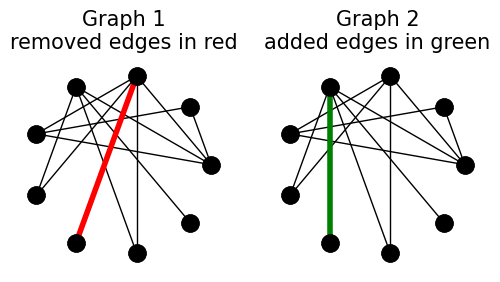

In [257]:
from plot import plot_difference_graphs

# figure settings
fs = 3
node_size = fs*50
edge_size = fs/3

# plot difference
plot_difference_graphs(G1, G2, fs=fs, fs_title=5, node_size=node_size, edge_size=edge_size)

## Compute cross-graph attention (node-to-node)

$\bullet$ Get node features (for a number of layers);
$\bullet$ Compute attention scores $a_k^{(m \rightarrow n)}$ as a softmax-normalized dot-product between $\mathbf{h}_k^{(n)}$ and $\mathbf{h}_k^{(m)}$, computed as:

$$
a_k^{(m \rightarrow n)} =
\frac{
\exp \left( \mathbf{h}_k^{(n)} \cdot \mathbf{g}_k^{(j)} \right)
}
{
\sum_{m'\in\mathcal{E}_2}{
\exp \left( \mathbf{h}_k^{(n)} \cdot \mathbf{g}_k^{(m')} \right)
}
};
$$

$\bullet$ Note that: $n \in \mathcal{N}_1$ and $m \in \mathcal{N}_2$, or vice versa. If indeed the other way around, $m' \in \mathcal{E}_1$;
$\bullet$ Average $a_k^{(m \rightarrow n)}$ and $a_k^{(n \rightarrow m)}$ to get $a_k^{(n, m)}$:

$$
a_k^{(n, m)} = a_k^{(m, n)} = \frac{a_k^{(m \rightarrow n)} + a_k^{(n \rightarrow m)}}{2};
$$
$\bullet$ $a_k^{(n, m)}$ is taken as the final attention weight;
$\bullet$ The attention weight reflects the similarity between two nodes $\longrightarrow$ in the plot the line thickness and color between two nodes depends on the attention weight.

In [258]:
# # Or by randomly generating
G1,_ = generate_binomial_graph(8, pe=0.2)
G2 = substitute_random_edges(G1, k=1)

In [259]:
def get_hidden_node_features(graphs, model, layers=[5]):

    # Set model to evaluation mode
    model.eval()

    # Combine two graphs into a disjoint
    G = nx.disjoint_union_all(graphs)
    G = from_networkx(G)

    # Prepare data
    edge_index = G['edge_index']  # edge index
    node_feats = torch.ones(G.num_nodes, cfg.model.node_dim)  # node features to all-ones
    edge_feats = torch.ones(G.num_edges, cfg.model.edge_dim)  # edge features to all-ones
    batch_id = torch.cat([
            i*torch.ones(graphs[i].number_of_nodes(), dtype=torch.int)
                for i in range(len(graphs))],
        dim=0)

    # Get node features
    with torch.no_grad():
        node_hidden_feats = model.get_node_features(edge_index, x1=node_feats, x2=None,
                                                    edge_feats=edge_feats, batch=batch_id,
                                                    layers=layers)

    return node_hidden_feats

In [260]:
from data import permute_graph_nodes

# Set layers for which attention is to be computed
layers = [1, 2, 3, 4, 5]

# Graphs
graphs = [G1, G2, G1, G2]

# Compute node features
node_hidden_feats = get_hidden_node_features(graphs, model, layers=layers)

# Print information on hidden node features
for k in layers:
    print(f"Size of {k}-th layer = {node_hidden_feats[k].shape}")

Size of 1-th layer = torch.Size([32, 32])
Size of 2-th layer = torch.Size([32, 32])
Size of 3-th layer = torch.Size([32, 32])
Size of 4-th layer = torch.Size([32, 32])
Size of 5-th layer = torch.Size([32, 32])


These are indeed the correct sizes. </br>
Every hidden node feature matrix has size 16 by 32. </br>
$\bullet$ 16 = number of nodes. Since $G_1$ and $G_2$ both have 8 nodes, the total equals 16.
$\bullet$ 32 = size of feature vector.

We can now compute attention between the first 8 nodes $n$ ($\in \mathcal{N}_1$) and the second 8 nodes $m$ ($\in \mathcal{N}_2$). </br>
We first test the attention on two matrices (that have a different size).

### Dummy scenario: two simple matrices

Very simple scenario (two simple matrices, with trivial vectors):

In [261]:
from model import cosine_distance_torch

def cross_attention(x, y, sim=cosine_distance_torch):
    """Computes attention between x an y, and y and x"""
    a = sim(x, y)
    a_x = torch.softmax(a, dim=1)  # n->m
    a_y = torch.softmax(a, dim=0)  # m->n
    return a_x, a_y

# Create dummy variables. Note: not the same amount of nodes.
x = torch.tensor([[1, 0, 0],  # x_1 (n=1)
                  [0, 1, 0],  # x_2 (n=2)
                  [0, 0, 1]]  # x_3 (n=3)
                 ).float()

y = torch.tensor([[1, 0, 0],  # y_1 (m=1)
                  [0, 1, 0]]  # y_2 (m=2)
                 ).float()

# Expectation:
# a_11 ~ 0.75 (same, but since normalized ...)
# a_12 ~ 0.25 (quite same, because normalized)
# a_21 ~ 0.25 (quite same, because normalized)
# a_22 ~ 0.75 (same, but since normalized ...)
# a_13 = a_23 = 0 (orthogonal)

# Compute cross attention
c_xy = cosine_distance_torch(x, y)
a_xy = cross_attention(x, y)

print("## Cosine similarity x and y:\n"
      f"{c_xy}\n")

# Print information
print("## Softmax-normalized dot-product")
for i, t in enumerate(["y > x", "x > y"]):
    print(f"### Attention {t}:\n{a_xy[i]}")

## Cosine similarity x and y:
tensor([[1., 0.],
        [0., 1.],
        [0., 0.]])

## Softmax-normalized dot-product
### Attention y > x:
tensor([[0.7311, 0.2689],
        [0.2689, 0.7311],
        [0.5000, 0.5000]])
### Attention x > y:
tensor([[0.5761, 0.2119],
        [0.2119, 0.5761],
        [0.2119, 0.2119]])


This looks good and the cosine similarity and softmax-normalized dot-products make sense.


### Cross-attention between two randomly sampled graphs

Now we can do it for the hidden node features. </br>
Let's check the node features first. </br>
Let's plot them to see

In [262]:
import matplotlib.pyplot as plt

def set_aspect_ratio(ax, ratio=1.0):

    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)


def plot_node_features(graphs, node_hidden_feats, layers=[5]):

    # Global settings
    fs = 8
    fc = "white"
    tc = "white" if fc == "black" else "black"

    # Set figure
    fig, axs = set_figure(len(layers), 2, fs=fs, fs_title=3, fs_axes=2.5, fs_xtick=2, fs_ytick=2, fc=fc)

    # Set title of figure as layer number
    # fig.suptitle(f"Node feature distribution")

    for k_idx, k in enumerate(layers):

        # Extract only hidden node features of the k-th layer
        node_feats_k = node_hidden_feats[k]

        # Get X- and Y-features separately for, resp., Graph 1 and 2.
        N1 = graphs[0].number_of_nodes()
        N2 = graphs[1].number_of_nodes()
        x = node_feats_k[:N1]
        y = node_feats_k[N1:N1+N2]

        # # Plot
        # fig, axs = set_figure(1, 2, fs=fs, fs_title=3, fs_axes=2.5, fs_xtick=2, fs_ytick=2, fc=fc)

        # Loop through data
        for i, data in enumerate([x, y]):

            # Set axis index
            ax = axs[k_idx * 2 + i]

            # Make up axis
            ax.spines['bottom'].set_color(tc)
            ax.spines['left'].set_color(tc)
            ax.tick_params(axis='x', colors=tc)
            ax.tick_params(axis='y', colors=tc)

            # Plot features
            ax.plot(np.array(data.t()))

            # Set axis labels
            ax.axis(True)
            ax.set_ylabel(f"Value", color=tc)
            ax.set_xlabel(f"Feature index", color=tc)

            # Set axis title
            ax.set_title(f"Graph {i+1} @ Layer {k}")

            # Set aspect
            # set_aspect_ratio(ax, ratio=ratio)

In [263]:
# Sampling of graphs
N = 8
G1,_ = generate_binomial_graph(N, pe=0.2)
G2 = substitute_random_edges(G1, k=1)

torch.Size([16, 32])


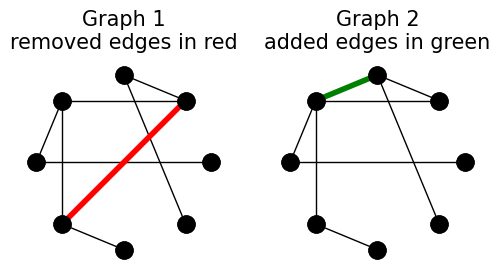

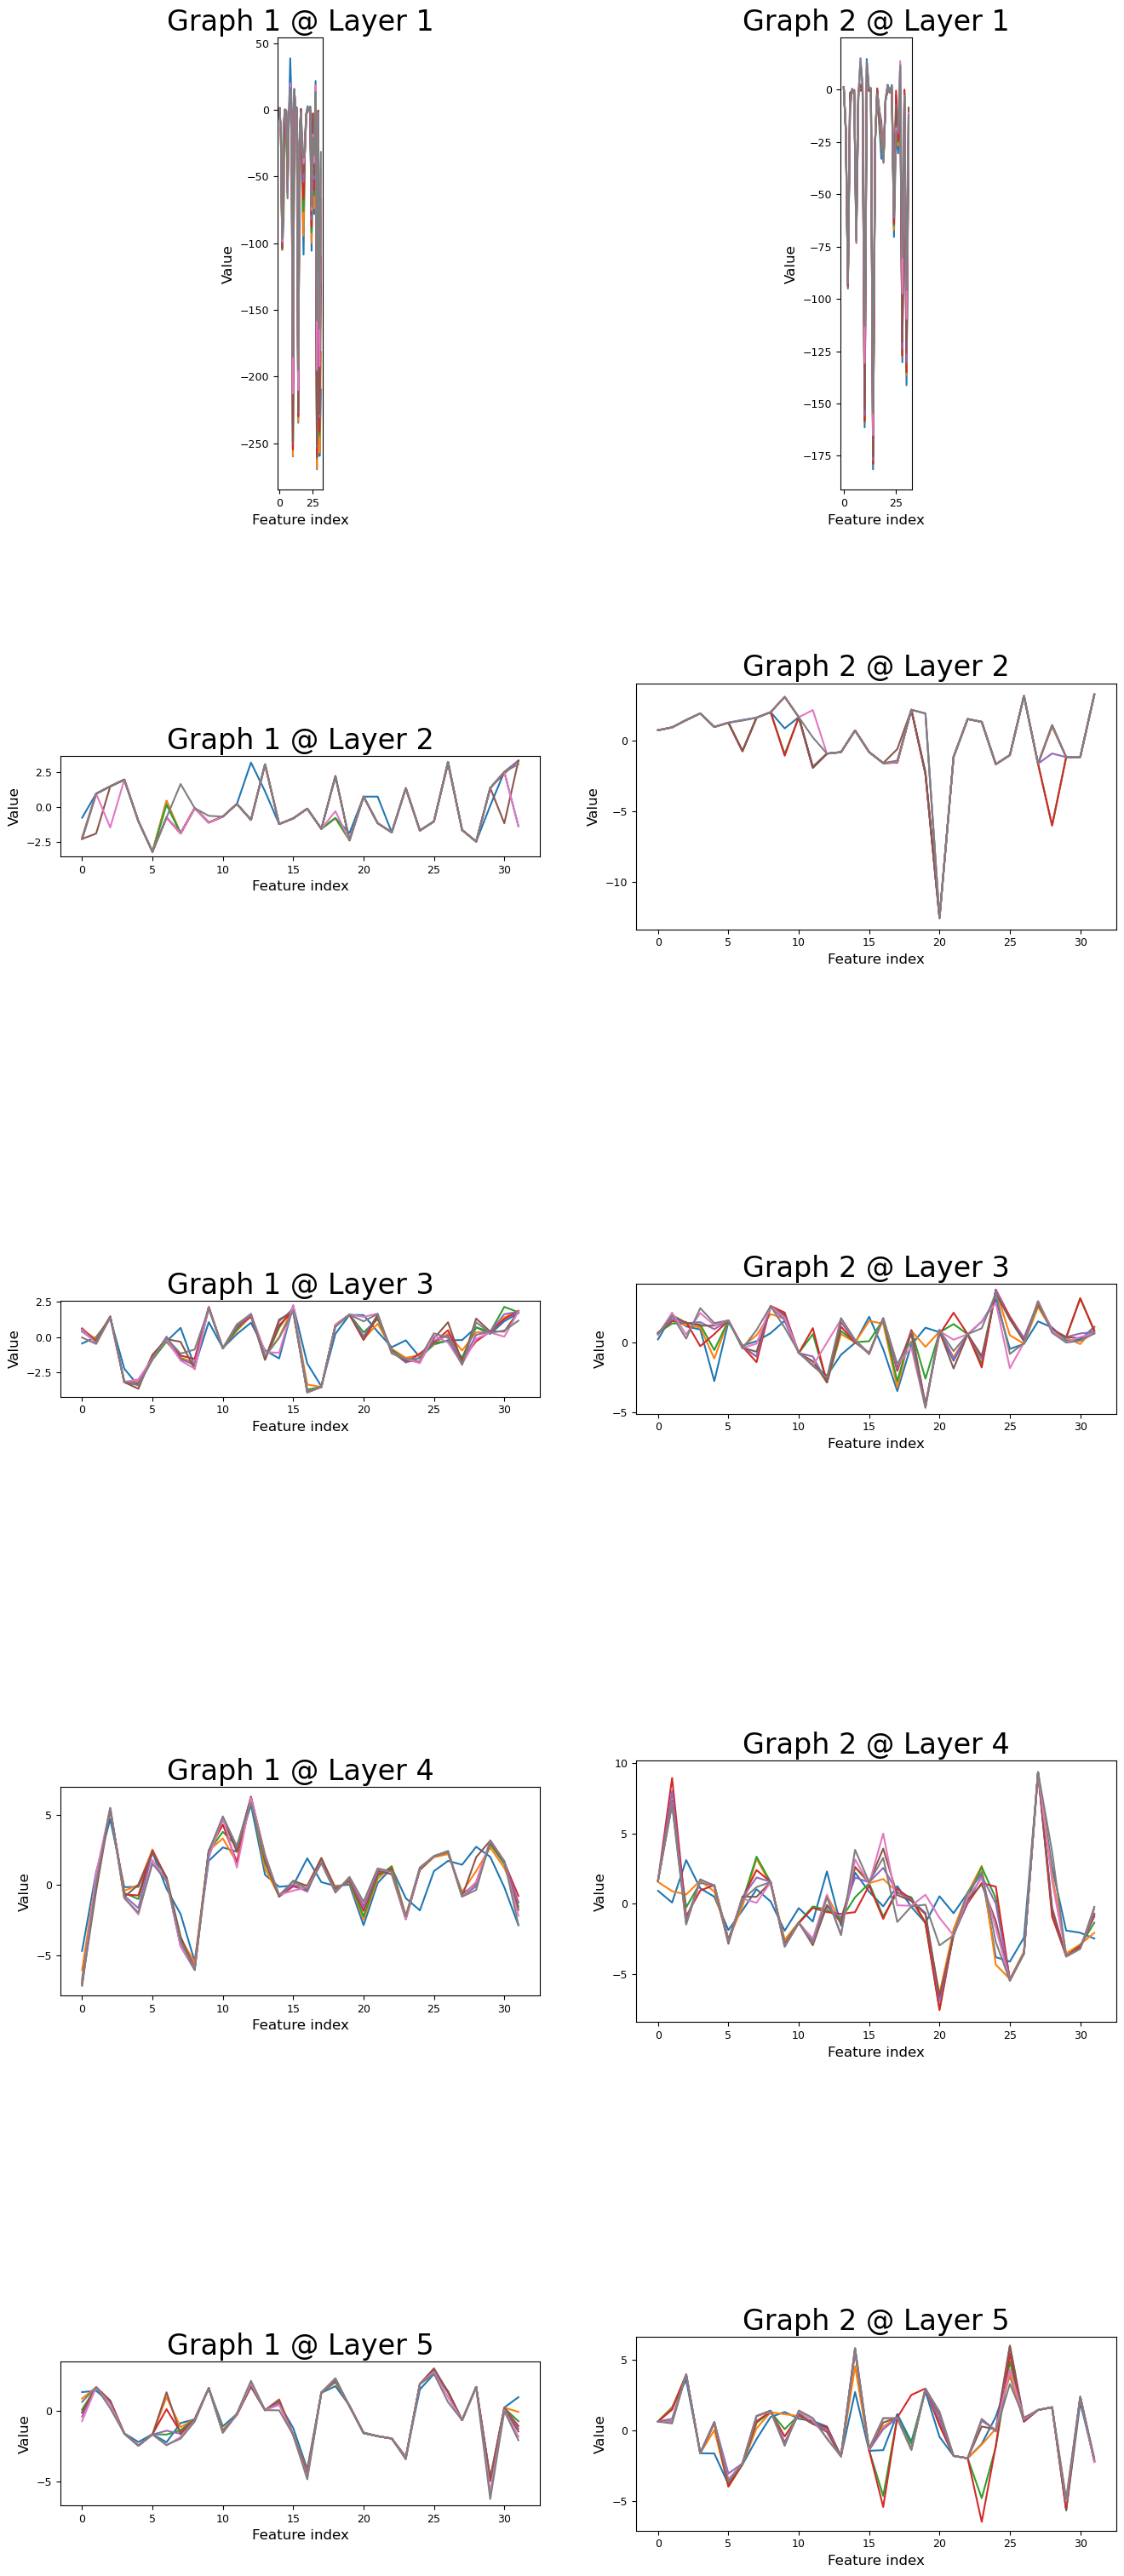

In [264]:
from plot import set_figure
import numpy as np

# PLOT 1: Graphs
# Figure settings
fs = 3
node_size = fs*50
edge_size = fs/3

# Plot difference
plot_difference_graphs(G1, G2, fs=fs, fs_title=5, node_size=node_size, edge_size=edge_size)

# Set layers
layers = [1, 2, 3, 4, 5]

# Compute node hidden features
graphs = [G1, G2]
node_hidden_feats = get_hidden_node_features(graphs, model=model, layers=layers)
print(node_hidden_feats[1].shape)

# Plot hidden node features
plot_node_features(graphs, node_hidden_feats, layers=layers)

Interestingly

In [265]:
def cosine_similarity(X, Y):
    """
    Compute the cosine similarity (or: normalized dot-products) between two sets of vectors.

    Parameters:
    X (torch.Tensor): Matrix of shape (N_x, D) representing the first set of vectors.
    Y (torch.Tensor): Matrix of shape (N_y, D) representing the second set of vectors.

    Returns:
    torch.Tensor: Matrix C of shape (N_x, N_y) with the normalized dot-products.
    """

    # Compute dot-product matrix
    P = torch.mm(X, Y.t())

    # Compute norms of both matrices
    Xn = torch.norm(X, dim=1)
    Yn = torch.norm(Y, dim=1)

    # Compute cosine similarity matrix
    C = torch.div(P, torch.outer(Xn, Yn))

    return C

# Extract only hidden node features of the 5-th layer
node_feats_5 = node_hidden_feats[5]
print(f"## Shape of node feature tensor:\n{node_feats_5.shape}\n")

# Compute cross-attention
N1 = graphs[0].number_of_nodes()
N2 = graphs[1].number_of_nodes()
x = node_feats_5[:N1]
y = node_feats_5[N1:N1+N2]
c_xy = cosine_similarity(x, y)
a_xy = cross_attention(x, y)

# Print information
print("## Cosine similarity x and y:\n"
      f"{c_xy}\n")

print("## Softmax-normalized dot-product")
for i, t in enumerate(["y > x", "x > y"]):
    print(f"### Attention {t}:\n{a_xy[i]}")

## Shape of node feature tensor:
torch.Size([16, 32])

## Cosine similarity x and y:
tensor([[0.6882, 0.5429, 0.6604, 0.7008, 0.4380, 0.4238, 0.3739, 0.3543],
        [0.6580, 0.5100, 0.6335, 0.6816, 0.4094, 0.3952, 0.3431, 0.3192],
        [0.7038, 0.5494, 0.6641, 0.7087, 0.4442, 0.4292, 0.3786, 0.3539],
        [0.6817, 0.5287, 0.6494, 0.6977, 0.4274, 0.4127, 0.3601, 0.3335],
        [0.7026, 0.5482, 0.6631, 0.7093, 0.4454, 0.4304, 0.3789, 0.3525],
        [0.6590, 0.5087, 0.6323, 0.6825, 0.4122, 0.3977, 0.3445, 0.3168],
        [0.7005, 0.5455, 0.6528, 0.6958, 0.4385, 0.4233, 0.3764, 0.3513],
        [0.6904, 0.5305, 0.6379, 0.6806, 0.4194, 0.4039, 0.3578, 0.3328]])

## Softmax-normalized dot-product
### Attention y > x:
tensor([[0.1461, 0.1264, 0.1421, 0.1480, 0.1138, 0.1122, 0.1067, 0.1047],
        [0.1459, 0.1258, 0.1424, 0.1494, 0.1138, 0.1122, 0.1065, 0.1040],
        [0.1475, 0.1264, 0.1417, 0.1482, 0.1137, 0.1121, 0.1065, 0.1039],
        [0.1468, 0.1260, 0.1421, 0.1492, 0.1

Something very strange is happening: </br>
Even though the first graph is (randomly) permuted, the attention scores are much higher for the first column ...

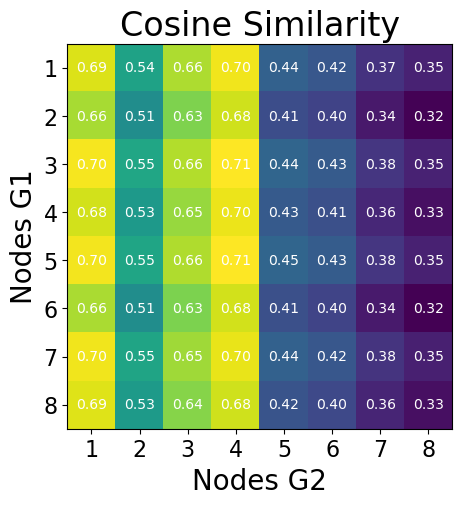

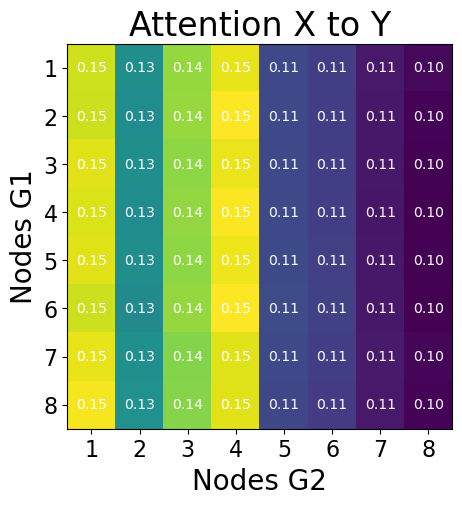

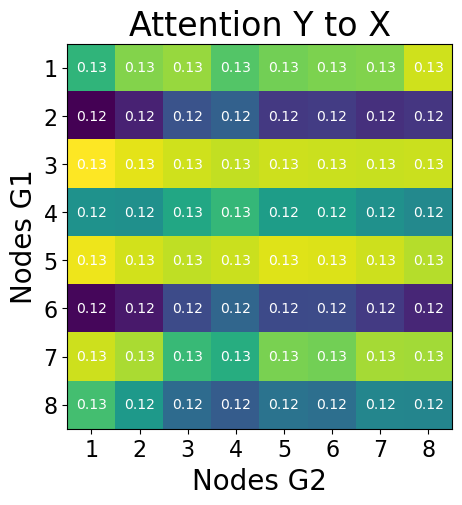

In [266]:
def plot_matrix_similarity(A, fs=10, title=None):

    # Sizes
    N1 = A.shape[0]
    N2 = A.shape[1]

    # Plot settings

    fig, ax = plt.subplots(1,1,figsize=(fs, fs))
    _ = ax.imshow(A, cmap='viridis')  # You can choose any colormap here
    # fig.colorbar(cax)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(N1), labels=np.arange(N1)+1)
    ax.set_yticks(np.arange(N2), labels=np.arange(N2)+1)

    # Loop over data dimensions and create text annotations.
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            ax.text(j, i, f'{A[i,j]:.2f}', va='center', ha='center', color='white', fontsize=fs*2*8/np.mean([N1, N2]))

    ax.set_xlabel('Nodes G2')
    ax.set_ylabel('Nodes G1')
    ax.set_title(title)

fs = 5
plot_matrix_similarity(c_xy, fs=fs, title="Cosine Similarity")
plot_matrix_similarity(a_xy[0], fs=fs, title="Attention X to Y")
plot_matrix_similarity(a_xy[1], fs=fs, title="Attention Y to X")